In [37]:
from moku.instruments import MultiInstrument, PIDController, FrequencyResponseAnalyzer
import control as ct
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [38]:
def PISDS_controller(prop_gain_dB,int_crossover,int_saturation_dB,diff_crossover,diff_saturation_dB):
    diff_saturation_mag = 10**(diff_saturation_dB/20)
    int_saturation_mag = 10**(int_saturation_dB/20)
    prop_gain_mag = 10**(prop_gain_dB/20)
    pid = ct.tf([1,diff_crossover,int_crossover*diff_crossover],[diff_crossover/prop_gain_mag,0])
    sat = ct.zpk([0],[-diff_crossover*diff_saturation_mag/prop_gain_mag,prop_gain_mag*int_crossover/int_saturation_mag],diff_crossover*diff_saturation_mag/prop_gain_mag)
    return ct.series(pid,sat)


In [39]:
#controller parameters:
prop_gain_dB=-30
int_crossover = 1e2
diff_crossover = 5e3
int_saturation_dB = 0
diff_saturation_dB = 20

In [40]:
#create model transfer function
model_TF = PISDS_controller(prop_gain_dB,int_crossover,int_saturation_dB,diff_crossover,diff_saturation_dB)

In [41]:
#Configure the MOKU to set and measure a PID controller with these parameters
MIM = MultiInstrument('192.168.50.97', force_connect=True, platform_id=4) #192.168.50.97 is the IP for Moku Pro 1

pid = MIM.set_instrument(1, PIDController)
fra = MIM.set_instrument(2, FrequencyResponseAnalyzer)

connections = [dict(source="Slot1OutA", destination="Slot2InA"),
               dict(source="Slot2OutA", destination="Slot1InA")]

MIM.set_connections(connections=connections)

[{'destination': 'Slot1InA', 'source': 'Slot2OutA'},
 {'destination': 'Slot2InA', 'source': 'Slot1OutA'},
 {'destination': 'Slot2InB', 'source': 'Slot1OutB'}]

In [42]:
#Set the PID controller
pid.set_by_frequency(channel=1, prop_gain=prop_gain_dB,int_crossover = int_crossover,diff_crossover = diff_crossover,int_saturation = int_saturation_dB,diff_saturation = diff_saturation_dB)
pid.enable_input(1, True)
pid.enable_output(1,True,True)

{'output': True, 'signal': True}

In [43]:
fra.set_sweep(start_frequency=10, stop_frequency=20e6, num_points=256,
                averaging_time=1e-3, averaging_cycles=1, settling_cycles=1,
                settling_time=1e-3)
fra.set_output(1, 0.01)

{'amplitude': 0.01, 'offset': 0.0}

In [44]:
delay = fra.start_sweep() 
print(delay)
data = fra.get_data(wait_complete = True)

{'estimated_sweep_time': 3.9502599500690194}


In [45]:

MIM.relinquish_ownership()

In [53]:
df = pd.DataFrame(data = data['ch1'])
#df = df.drop(columns = 'phase')

df

,frequency,magnitude,phase
0,9.999992e+00,-10.224918,-49.016360
1,1.058546e+01,-11.186249,-64.374536
2,1.120520e+01,-11.626358,-65.193041
3,1.186122e+01,-12.068259,-65.774015
4,1.255565e+01,-12.513421,-66.284551
...,...,...,...
251,1.592907e+07,20.196660,-109.860830
252,1.686166e+07,20.156783,157.754912
253,1.784885e+07,20.112163,59.792971
254,1.889383e+07,20.067532,-44.111019


In [54]:
(model_mag ,model_phase, omega) =  model_TF.freqresp(omega = df['frequency'])
model_mag_dB = 20*np.log10(model_mag)
df.insert(2,"model mag",model_mag_dB)
print(df)

        frequency  magnitude  model mag       phase
0    9.999992e+00 -10.224918 -10.372427  -49.016360
1    1.058546e+01 -11.186249 -10.818977  -64.374536
2    1.120520e+01 -11.626358 -11.269167  -65.193041
3    1.186122e+01 -12.068259 -11.722539  -65.774015
4    1.255565e+01 -12.513421 -12.178658  -66.284551
..            ...        ...        ...         ...
251  1.592907e+07  20.196660  19.957420 -109.860830
252  1.686166e+07  20.156783  19.961980  157.754912
253  1.784885e+07  20.112163  19.966053   59.792971
254  1.889383e+07  20.067532  19.969692  -44.111019
255  2.000000e+07  20.008914  19.972941 -154.387917

[256 rows x 4 columns]


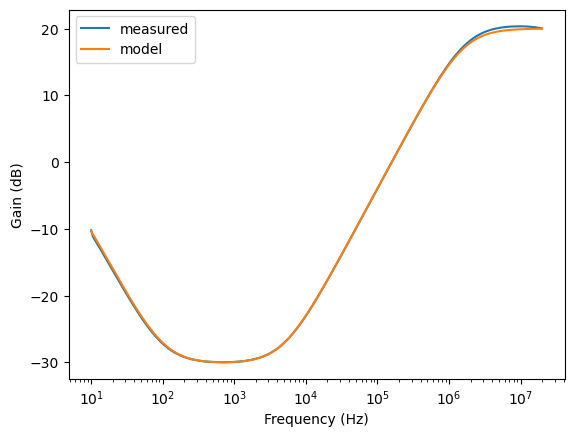

In [55]:
plt.semilogx(df['frequency'],df['magnitude'])
plt.semilogx(df['frequency'],df['model mag'])
plt.legend(['measured','model'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.show()